# **TEXT PREPROCESSING FUNCTION**

In [50]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt

In [51]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [52]:
def clean_comments (filepath):
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [53]:
def clean_submissions(filepath):
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [54]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/corpus_v5.csv',
 '../Data/corpus_v4.csv',
 '../Data/filtered_corpus.csv',
 '../Data/corpus_v3.csv',
 '../Data/corpus_v2.csv',
 '../Data/full_posts.csv',
 '../Data/training_data.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/sampled_subset.csv',
 '../Data/training_corpus.csv',
 '../Data/comments.csv',
 '../Data/corpus.csv']

In [55]:
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅
...,...,...,...,...,...
130047,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ..."
130048,submission,14f4uyi,2023-06-21 15:15:27,2023,Found the r/dubai redditors who kept telling m...
130049,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...
130050,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...


In [56]:
year_group = data.groupby(by='year')
for year, group in year_group:
    print (year,len(group))

2012 11
2013 60
2014 143
2015 206
2016 787
2017 1131
2018 1685
2019 4238
2020 29987
2021 28188
2022 36775
2023 26841


## **TEXT PREPROCESSING**

### **Convert all Text to Lowercase**

In [57]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
19697,comment,j018wd6,2022-12-13 14:06:10,2022,Abood ???,abood ???
128453,submission,13a72ew,2023-05-07 04:19:22,2023,I crashed my moms car without a license So lon...,i crashed my moms car without a license so lon...
34099,comment,ik5kj5l,2022-08-13 21:54:29,2022,Bro im 16 and have hair fall what are u saying 💀,bro im 16 and have hair fall what are u saying 💀
110888,comment,h54hp9x,2021-07-14 09:40:00,2021,Yes it is most of them left because there were...,yes it is most of them left because there were...
75847,comment,eeragnc,2019-01-23 14:05:31,2019,Meanwhile in the right lanes where everyone is...,meanwhile in the right lanes where everyone is...


## **Expand Word Contractions**

In [58]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
45400,comment,gt0hb6h,2021-04-01 13:35:33,2021,Agreed. Applicable worldwide and makes most se...,agreed. applicable worldwide and makes most se...
75668,comment,irkc0cj,2022-10-09 02:27:45,2022,You're an international Chammak,you are an international chammak
67049,comment,ipyyo7r,2022-09-26 17:56:20,2022,[Other outlets](https://www.arabianbusiness.co...,[other outlets](https://www.arabianbusiness.co...
21726,comment,inasear,2022-09-06 15:06:40,2022,Same,same
43860,comment,j2cmme4,2022-12-31 10:32:15,2022,[removed],[removed]


## **Remove URLs**

In [59]:
#pd.reset_option('display.max_colwidth')

In [60]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music https://youtu....
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
94,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,https://www.instagram.com/p/ckhzbwph0c4/?igshi...
174,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
293,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\nhttps://maps.app.go...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


In [61]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
94,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,\n\nhere is a video explaining the same.
174,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
293,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\n \n\nthen follow th...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


## **Remove Accents from Characters**

In [62]:
data['clean_text'] = data['clean_text'].apply(
                                            lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
106072,comment,j5w9whx,2023-01-26 04:22:49,2023,Ive never heard anyone say that even some part...,i have never heard anyone say that even some p...
52556,comment,je7o7g2,2023-03-30 04:24:38,2023,Reminds me of eid morning prayer lol,reminds me of eid morning prayer lol
128421,submission,hxnuuo,2020-07-25 18:45:21,2020,40000 Aed a good salary? I am Radiologist havi...,40000 aed a good salary? i am radiologist havi...
18288,comment,is0cgt4,2022-10-12 15:42:51,2022,"in 2014 it did feel very busy, but all the yea...","in 2014 it did feel very busy, but all the yea..."
16802,comment,i2qy6mv,2022-03-30 22:42:13,2022,"Unacceptable, file a complaint on Google revie...","unacceptable, file a complaint on google revie..."


## **Remove Punctuations**

In [63]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

[125797, 126266, 127896, 128038, 128385]


In [64]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(r'[^\w\s]', ' ', text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello \n\nthis ...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove New Line & Tab**

In [65]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this is...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove Digits**

In [66]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join (word for word in text.split() if word.isalpha()))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
91827,comment,jo80lqi,2023-06-15 17:10:24,2023,The hate group that coined this “woke” bashing...,the hate group that coined this woke bashing t...
38918,comment,ji0ypmw,2023-04-28 11:22:59,2023,"Congratulations buddy, don't worry those 7 att...",congratulations buddy do not worry those attem...
58699,comment,joqqucc,2023-06-19 23:38:46,2023,So much this.\n\nLovin Dubai and some people o...,so much this lovin dubai and some people on th...
48939,comment,ianagho,2022-05-31 14:20:11,2022,Explain why most people come to the roundabout...,explain why most people come to the roundabout...
94999,comment,j4fozwy,2023-01-15 15:25:01,2023,"Just be careful, even if it's a Rolex authoriz...",just be careful even if it is a rolex authoriz...


## **LEMMATIZATION**

In [67]:
nlp = spacy.load('en_core_web_md')

In [68]:
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(' '.join(text))])
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(text)])
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(token.lemma_ for token in nlp(text)))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guy we make it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hello d...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who be ask for money groce...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any ...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone I be currently look for job tempor...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for ...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas be at high risk of fire during the ...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this be t...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with apply for residency confuse abo...


## **Remove Stop Words - SpaCy**

In [69]:
nlp = spacy.load('en_core_web_md')

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word.text for word in nlp(text) if not word.is_stop]))

data.sample(n=10)

,text_type,ID,date_created,year,long_text,clean_text
115802,comment,j1mp9dj,2022-12-25 21:48:42,2022,Have you decided what you want to buy and sell...,decide want buy sell sell item receive payment...
71174,comment,j0gdtze,2022-12-16 17:23:04,2022,Try [here.](https://www.google.com/search?q=fa...,try google fashion stylist dubai contact apply...
90672,comment,jekphan,2023-04-01 23:47:36,2023,Women ☕️,woman
44486,comment,fr57p3h,2020-05-19 19:59:09,2020,"Awesome, good luck!",awesome good luck
66386,comment,jfob4u5,2023-04-10 12:59:36,2023,Yes yes absolutely the same way pork is not al...,yes yes absolutely way pork allow microwave of...
96091,comment,fkniyaw,2020-03-16 17:54:57,2020,Sounds like a plan brother,sound like plan brother
8246,comment,h90swrs,2021-08-15 16:03:06,2021,Entitled pieces of shi- lazy people...,entitle piece shi lazy people
105314,comment,ig3keja,2022-07-14 11:06:25,2022,"No problem habibi, English is same same, just ...",problem habibi english send address watsapp
107666,comment,h99acuk,2021-08-17 10:01:04,2021,i have done a few pcrs there it’s quick to get...,pcr quick receive pcr result alhosn text messa...
106058,comment,hr3sa23,2022-01-03 22:39:24,2022,You still need to transfer your license from a...,need transfer license country ok consider coun...


In [70]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

common_words_tuples= fdist.most_common(100)
common_words = [word for word, freq in common_words_tuples]

#rare_words_dict = fdist.most_common()[-20:-1]
rare_words = [word for word, freq in fdist.items() if freq <= 10]

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (len(common_words),'\n\n',rare_words)
print (f'Common words: The top 20 most common words in the dataset are: {common_words}')
print ('\n')
print (f'Rare words: There are {len(rare_words)} words that occur less than or equal to 10 times in the dataset')

Common words: The top 20 most common words in the dataset are: ['people', 'like', 'dubai', 'know', 'good', 'time', 'think', 'work', 'use', 'want', 'country', 'year', 'need', 'uae', 'thing', 'pay', 'come', 'day', 'look', 'way', 'thank', 'try', 'car', 'right', 'live', 'place', 'find', 's', 'ask', 'job', 'guy', 'post', 'company', 'lot', 'mean', 'sure', 'tell', 'feel', 'life', 'yes', 'bad', 'money', 'lol', 'home', 'help', 'happen', 'month', 'new', 'let', 'drive', 'point', 'case', 'leave', 'man', 'world', 'friend', 'start', 'buy', 'long', 'experience', 'actually', 'comment', 'change', 'maybe', 'high', 'issue', 'person', 'hope', 'fine', 'food', 'talk', 'free', 'check', 'price', 'love', 'kid', 'business', 'great', 'different', 'big', 'etc', 'stop', 'family', 'number', 'end', 'police', 'understand', 'lane', 'city', 'probably', 'reason', 'yeah', 'nice', 'hear', 'al', 'service', 'visa', 'kind', 'remove', 'salary']


Rare words: There are 32085 words that occur less than or equal to 10 times in t

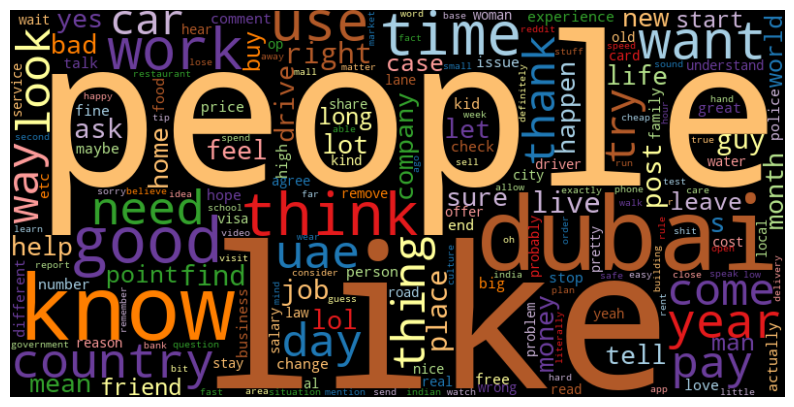

In [71]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [72]:
#create custom stop words list
custom_sw = rare_words + common_words #create list holding common and rare words
custom_sw = set(custom_sw) #remove any duplicates

len(custom_sw)

32185

In [73]:
#remove custom stop words from dataset
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

,text_type,ID,date_created,year,long_text,clean_text
21670,comment,fuzmair,2020-06-16 11:12:02,2020,Actual Title: \n\nSTRIPPED OF HER RIGHTS Brit ...,actual title strip brit mum trap husband flee ...
40114,comment,j2t03bj,2023-01-03 23:19:06,2023,"Hahaha. It's too damn funny, talking about cri...",hahaha damn funny critical thinking foundation...
127653,submission,ve87gn,2022-06-17 12:21:34,2022,I am planning to buy an iPhone in a couple of ...,plan iphone couple meena bazaar suggestion sho...
51362,comment,g2c9cck,2020-08-21 20:32:57,2020,"Geez, just move on already. Its a meme in engl...",geez meme english happiness sad simple
69462,comment,e3y9kts,2018-08-10 18:36:34,2018,She was detained because she landed in the cou...,detain land child scream custom insult refuse ...


In [74]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

#common_words = fdist.most_common(10)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in fdist.most_common(10):
    common_words_table.add_row([word, count])

print (common_words_table)

+---------+-------+
|   word  | count |
+---------+-------+
|  agree  |  1864 |
|   stay  |  1862 |
|   road  |  1847 |
|   read  |  1829 |
|    op   |  1822 |
| problem |  1807 |
|  driver |  1796 |
|   cost  |  1789 |
|   real  |  1764 |
|  woman  |  1749 |
+---------+-------+


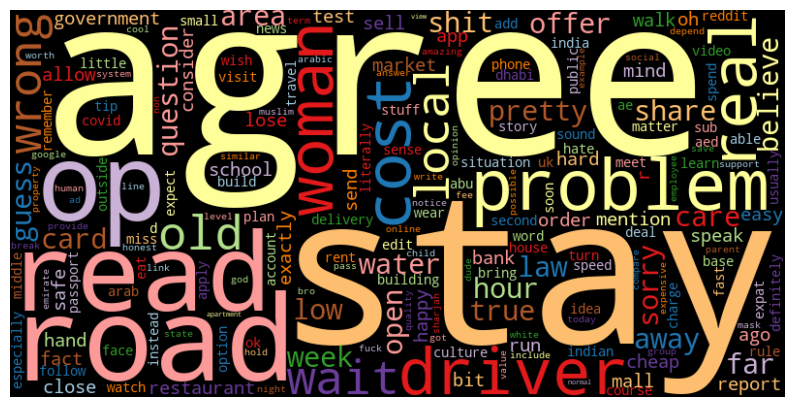

In [75]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Remove Extra Whitespaces**

In [76]:
data['clean_text'] = data['clean_text'].str.strip().str.replace('\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391, 129297]

#redo word_count
#data['word_count'] = data['clean_text'].apply (lambda text: len(text.split()))

data.loc[sample_rows]#.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text
5786,comment,ji7mk4q,2023-04-29 22:19:10,2023,This really isnt news.\n\nThe UAE has always b...,news indian entrepreneur stat indian millionai...
18460,comment,j5nec03,2023-01-24 09:49:19,2023,Creep,creep
103391,comment,d57mm8v,2016-07-11 11:42:56,2016,Intellectuals meet with other intellectuals.,intellectual meet intellectual
129297,submission,ks5wh3,2021-01-07 08:46:06,2021,Recommendations for South Indian food tiffin s...,recommendation south indian recommendation lun...


## **Word Tokenization - NLTK**

In [77]:
data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text,tokens
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,yay,[yay]
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia nz hello rece...,"[psa, immigration, canada, australia, nz, hell..."
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,reach grocery normally ignore allow support be...,"[reach, grocery, normally, ignore, allow, supp..."
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,plan spend eid holiday fun activity trip line ...,"[plan, spend, eid, holiday, fun, activity, tri..."
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi currently temporary permanent license thankful,"[hi, currently, temporary, permanent, license,..."
...,...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,uni qualification letter master application co...,"[uni, qualification, letter, master, applicati..."
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas risk fire summer community fire kil...,"[psa, villas, risk, fire, summer, community, f..."
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello daily ran...,"[daily, random, discussion, thread, hello, dai..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,apply residency confuse order step land enter ...,"[apply, residency, confuse, order, step, land,..."


## **Insert Word Count**

In [78]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia nz hello rece...,"[psa, immigration, canada, australia, nz, hell...",976
126553,submission,jh5hjq,2020-10-24 12:29:05,2020,List of discounts and working promo codes in D...,list discount promo code hello list discount p...,"[list, discount, promo, code, hello, list, dis...",739
5785,comment,ji1smg1,2023-04-28 17:10:21,2023,"FULLTEXT\nApr 27, 2023\n\nStand in the middle ...",apr stand middle meena bazaar hard imagine mil...,"[apr, stand, middle, meena, bazaar, hard, imag...",503
18459,comment,jj2t0ih,2023-05-06 15:40:03,2023,"FULL TEXT:\n\nBy Archana Narayanan, Abeer Abu ...",text abu omar bloomberg gamble industry bet un...,"[text, abu, omar, bloomberg, gamble, industry,...",466
127804,submission,10kwnuo,2023-01-25 15:37:29,2023,A complete list of LIFE HACK / TIPS / FACTS ab...,complete list hack tip fact progress update li...,"[complete, list, hack, tip, fact, progress, up...",462
...,...,...,...,...,...,...,...,...
89939,comment,fzzd9eq,2020-08-01 17:33:44,2020,Where is the orgasm then!?,,[],0
49611,comment,grq7k0b,2021-03-21 22:45:16,2021,McChicken,,[],0
68314,comment,gmsysci,2021-02-10 14:55:26,2021,It's look Great 🤜🏼🤛🏼,,[],0
121555,comment,ghhj8x0,2020-12-30 13:59:28,2020,What,,[],0


## **Remove Short Text Entries**

In [79]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('sample_subset_index.txt', 'r') as file:
    subset_index = [line.strip() for line in file]

subset_index[:5]

['hbbcq6z', 'hjjhl9r', 'h7ntxws', 'h02sz1n', 'hnuysoa']

In [80]:
#create unlabelled sample subset 
subset_data = data[data['ID'].isin(subset_index)]
subset_data

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
236,comment,ewm2xjg,2019-08-11 20:46:18,2019,"Except for some of the specific details, this ...",specific detail describe feeling perfectly for...,"[specific, detail, describe, feeling, perfectl...",57
270,comment,fb68ezr,2019-12-17 04:52:52,2019,It's so touching to see bromance develop betwe...,develop,[develop],1
282,comment,ewm7kp0,2019-08-11 21:37:06,2019,*Most* Indians have degrees in computer scienc...,indians degree computer science adult indian p...,"[indians, degree, computer, science, adult, in...",11
759,comment,josli8t,2023-06-20 08:35:18,2023,Wow. That's very interesting to know. Thanks ...,wow interesting share,"[wow, interesting, share]",3
775,comment,josux9n,2023-06-20 10:28:16,2023,Currently it’s gonna cost around 70K per annum...,currently cost annum bayut property finder,"[currently, cost, annum, bayut, property, finder]",6
...,...,...,...,...,...,...,...,...
129360,submission,wbwik,2012-07-10 19:11:08,2012,Only in Dubai! R8: BRAND NEW 2012 Audi R8 V8 -...,brand audi unwanted gift,"[brand, audi, unwanted, gift]",4
129739,submission,rxnqln,2022-01-07 00:11:25,2022,Himalayan Salt Lamp....? Where in UAE can I ge...,salt lamp authentic salt lamp trust internet,"[salt, lamp, authentic, salt, lamp, trust, int...",7
129806,submission,l8ttxz,2021-01-30 23:43:43,2021,"After the passing of someone, what can I do wi...",passing medication recently pass away medicati...,"[passing, medication, recently, pass, away, me...",33
129977,submission,14divtq,2023-06-19 20:12:58,2023,"Exchange house in Dubai Hey guys, \n\nLeaving ...",exchange house hey soon dirham dollar euro loo...,"[exchange, house, hey, soon, dirham, dollar, e...",9


In [47]:
#select only rows with more than 1 word
corpus = data[data['word_count'] > 2]

corpus.shape

(82544, 8)

## **Remove Subset for manual labelling**

In [139]:
#remove randomly sampled subset

subset_index = corpus[corpus['ID'].isin(subset_index)].index.to_list()

#remove sample subset from corpus

training_data = corpus.drop(subset_index, axis = 0)
training_data.sort_values(by='word_count', ascending = False)

training_data

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel past,"[single, travel, past]",3
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,shop dragon mart,"[shop, dragon, mart]",3
5,comment,gthiiwi,2021-04-05 23:18:56,2021,"That’s just absolutely hilarious, is this in t...",hilarious spring souk,"[hilarious, spring, souk]",3
13,comment,gtgfl4c,2021-04-05 18:21:42,2021,Is reel cinema and roxy part of emaar?,reel cinema roxy emaar,"[reel, cinema, roxy, emaar]",4
18,comment,gth5wdv,2021-04-05 21:42:41,2021,An innocent redditor here...can someone pls ex...,innocent pls explain everyday,"[innocent, pls, explain, everyday]",4
...,...,...,...,...,...,...,...,...
130046,submission,14f49ta,2023-06-21 14:45:45,2023,Legal advice needed. Would highly appreciate i...,legal highly legal highly private involved par...,"[legal, highly, legal, highly, private, involv...",10
130047,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",beauty saloon fella wife real saloon beauty sa...,"[beauty, saloon, fella, wife, real, saloon, be...",17
130049,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card april ...,"[scam, healthy, line, sister, cbd, debit, card...",35
130050,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...,expo property expo sale pleasant price locate ...,"[expo, property, expo, sale, pleasant, price, ...",9


In [142]:
"""#save corpus 
filename = '../Data/full_data.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    training_data.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')"""

file saved


## **Translate Emoticons**

In [ ]:
"""def find_emoji(text):
    try:
        emoticon_details = next(emoji.analyze(text, join_emoji=True))
        emoticon = emoticon_details.chars
        #translated_emoji = emoji.demojize(emoticon.chars)
    except StopIteration:
        emoticon = ''  # Handle the case when no emoji is found
    return  emoticon

data['emoticons'] = data['long_text'].apply (lambda text: find_emoji(text) )
data['translated_emojis'] = data['emoticons'].apply(lambda text: emoji.demojize(text))

emoji_index = [3709,33734,129114,100878]

data.loc[emoji_index]"""